In [78]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from InputSetup import FFInputCreation as inputCreation
from ParameterManipulation import createTSParamFiles, createFFParamFiles, copyNominalFiles
from stochasticTurbulenceTools_mod import stochasticTurbulence

#### A few input parameters. If # of seeds does not apply, can set to one or modify other parts of this script to remove it.

In [79]:
nSeeds = 2

# Z_bot= 10
# GridHeight = 100
# GridWidth = 100 
# D_grid = np.min(GridWidth,GridHeight)
# HubHt = Z_bot + GridHeight -(0.5*D_grid)
# This seems to happen in TSCaseCreation automatically
HubHt = 88.5
D=127

In [80]:
workdir='/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/'
os.chdir(workdir)

### Create cases based on ranges or discrete values?

In [81]:
Ranges = False

### Read in case parameters

In [136]:
if Ranges == False:
    ParamVals = pd.read_csv(os.path.join(workdir,'SampleFiles/ParamValues_KingPlains.csv'), header=None,index_col=0,delimiter=',')
    nTurbs = int(ParamVals.shape[0]/3)
    nCases = int(ParamVals.shape[1])
else:
    #writeParamVals()
    OrigVals = pd.read_csv(os.path.join(workdir,'SampleFiles/ParamRanges.csv'), names=['Var','MinVar','MaxVar','NomVar'])
    OrigVals = OrigVals['NomVar']

In [137]:
ParamVals

,1
0,
TI,A
Vhub,4.5
Shear,0.1
T1x-locs,0.0
T1y-locs,0.0
T2x-locs,6796.19
T2y-locs,4170
T3x-locs,6796.19
T3y-locs,-2015.79


##### Detect the number of turbines in the simulation; this will have to be modified based on your input file

In [138]:
nTurbs=int(ParamVals[3:].shape[0]/2)

In [139]:
nTurbs

3

In [155]:
nCases=ParamVals.shape[1]

1

### This section can be modified based on how you want to name your directory structure

In [156]:
caseNames=['None']*nCases
for case in range(nCases):
    if case < 10:
        case = '0'+str(case)
    caseNames[int(case)] = 'Case{0}'.format(case)
    
ParamVals.columns=caseNames

### This section creates the directory structure and copies any nominal files from a specified directory to all directories created here. This will have to be modified based on the directory structure you want and the files you want to copy

In [157]:
os.getcwd()

'/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm'

In [159]:
for case in range(nCases):
    name1=caseNames[case]
    if not os.path.exists(name1):
        os.makedirs(name1)
    os.chdir(name1)
    print(os.getcwd())
    copyNominalFiles(nSeeds,nTurbs)
    os.chdir('..')
os.chdir('..')

os.chdir(workdir)

/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case00/Seed_0/Case00
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case00/Seed_0/Case00/Seed_0
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case00/Seed_0/Case00/Seed_1


# Create TurbSim Files

## The following command creates the .inp files for the low- and high-resolution domains, as well as a .inp file for each turbine in the simulation.

In [160]:
os.chdir(workdir)

/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case00/Seed_0
Writing TurbSim input file:  TSParams.txt
-459.9271345 459.9271345
Writing a new Low.inp file from scratch
Writing a new HighT1.inp file from scratch
Writing a new HighT2.inp file from scratch
Writing a new HighT3.inp file from scratch
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case00/Seed_1
Writing TurbSim input file:  TSParams.txt
-459.9271345 459.9271345
Writing a new Low.inp file from scratch
Writing a new HighT1.inp file from scratch
Writing a new HighT2.inp file from scratch
Writing a new HighT3.inp file from scratch


/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/InputSetup.py:97: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('TSLayout.pdf',bbox_to_inches='tight',dpi=500)
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/InputSetup.py:97: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('TSLayout.pdf',bbox_to_inches='tight',dpi=500)


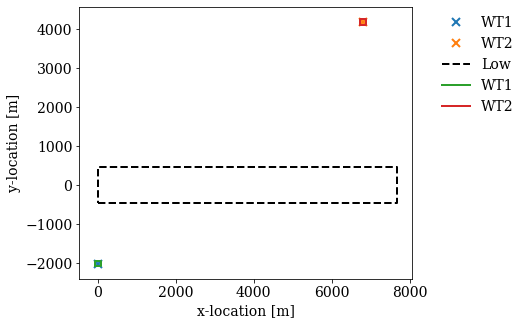

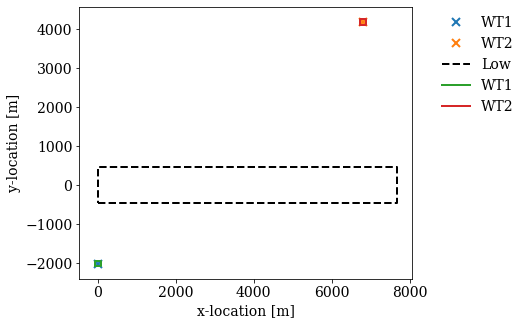

In [161]:
createTSParamFiles(caseNames,nSeeds,ParamVals,D,HubHt,'TSParams.txt')

## Determine Low-Res Domain Area 

### Read Turbine Locations and rotate the domain accoring to the directional discretization required


In [164]:
Yaw = pd.read_csv('KingPlainsDirectionSweepInfo.csv', header=None,index_col=0,delimiter=',')
nCases = int(Yaw.shape[1])
caseNames=['None']*nCases
for case in range(nCases):
    caseNames[int(case)] = 'Case_{0}'.format(case)
    
    
Yaw.columns=caseNames

In [165]:
Yaw

,Case_0,Case_1,Case_2,Case_3,Case_4,Case_5
0,,,,,,
WindDir,-15,-10,0,5,10,15
Misalignment,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE
WakeSteer,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


### Specify Turbine Locations

In [166]:
turblocs= pd.read_csv('KingPlainsTurbineLocations.csv',header=1)
xlocs_OG = turblocs.x_rotated
ylocs_OG = turblocs.y_rotated #[0,0,0,0,0,1852.000,1852.000,1852.000,1852.000,3704.000,3704.000,3704.000,]
nTurbs = len(xlocs_OG)
r=np.zeros(nTurbs)
ylocs_new = {case:{turb:{} for turb in range(nTurbs)}for case in range(nCases)}
xlocs_new = {case:{turb:{} for turb in range(nTurbs)}for case in range(nCases)}
for turb in range(nTurbs):
    r[turb] = np.sqrt(xlocs_OG[turb]**2+ylocs_OG[turb]**2)

In [167]:
turblocs

,Turbine#,x_rotated,y_rotated,z
0,0,19678.4069,7386.65328,0
1,1,17497.0140,11177.42380,0
2,2,22045.8782,6393.54067,0
3,3,19039.2543,10213.55400,0
4,4,18326.2961,11129.18130,0
5,5,16881.7469,9169.15472,0
6,6,17580.4701,6115.94876,0
7,7,17872.2194,11062.49030,0
8,8,18164.6694,9130.29568,0
9,9,18574.0937,9127.64773,0


### Plot the turbine locations


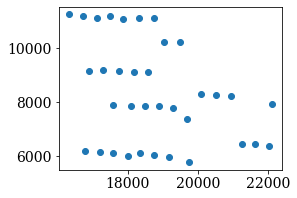

In [169]:
fig = plt.figure(figsize=(4,3))
# plt.plot([-126,9000,9000,-126,-126],
#         [-9900,-9900,9900,9900,-9900],'--k',lw=2,label='Low')
plt.scatter(xlocs_OG,ylocs_OG)

### Rotate the layout for each yaw angle case and determine max domain extents

In [170]:
for index,case in enumerate(caseNames):
    print(index)
    theta = np.float(Yaw[case]['WindDir'])
    ylocs_new[index][0]=0
    xlocs_new[index][0]=0
    for turb in range(nTurbs):
        if xlocs_OG[turb] != 0:
            theta_rot = np.arctan(ylocs_OG[turb]/xlocs_OG[turb])+np.radians(theta)
            ylocs_new[index][turb] = r[turb]*np.sin(theta_rot)
            xlocs_new[index][turb] = r[turb]*np.cos(theta_rot)
            
    xoff = min(xlocs_new[index].values())
    ymax=4170
    for turb in range(nTurbs):
        xlocs_new[index][turb]=xlocs_new[index][turb]-xoff
        if ylocs_new[index][turb] > ymax:
            ymax=ylocs_new[index][turb]
            print(ymax)
    if ymax > 4170.0:
        for turb in range(nTurbs):
            ylocs_new[index][turb]=ylocs_new[index][turb]-(ymax-4170)           


0
6268.001864172663
6648.9004172297555
1
7969.28902123041
8250.744797723017
2
7386.653279999999
11177.423800000002
11254.341
3
9073.631003638144
12659.855578920668
12684.073353570813
12689.413990878933
4
10691.552916530403
14045.938212655945
14142.43195006806
14184.657479209622
5
12228.105655991712
15325.122775423535
15493.158099991399
15571.947159193163


### Plot the layouts for validation

New minimum X Value is: 0.0
New maximum X Value is: 6796.188259837518
New minimum Y Value is: -2015.7858083606827
New maximum Y Value is: 4170.0


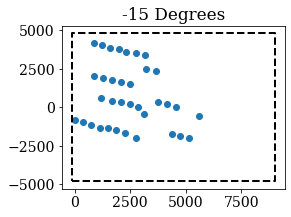

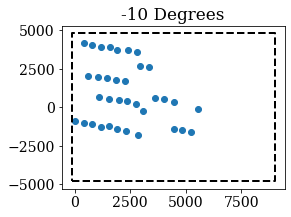

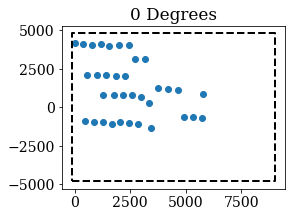

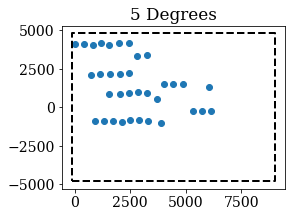

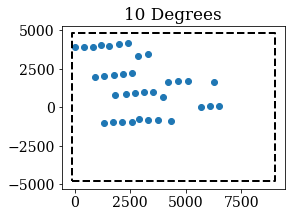

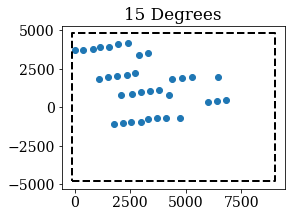

In [185]:
x_min_new = 9999
x_max_new = 0
y_min_new = 9999
y_max_new = 0
for index,case in enumerate(caseNames):
    fig = plt.figure(figsize=(4,3))
    plt.plot([-126,9000,9000,-126,-126],
            [-4800,-4800,4800,4800,-4800],'--k',lw=2,label='Low')
    plt.scatter(xlocs_new[index].values(),ylocs_new[index].values())
    plt.title(Yaw[case].WindDir + " Degrees")
    #Determine new absolute mins and maxes for x and y coords
    x_min = min(xlocs_new[index].values())
    x_max = max(xlocs_new[index].values())
    y_min = min(ylocs_new[index].values())
    y_max = max(ylocs_new[index].values())
    
    if x_min < x_min_new:
        x_min_new = x_min
    if x_max > x_max_new:
        x_max_new = x_max
    if y_min < y_min_new:
        y_min_new = y_min
    if y_max > y_max_new:
        y_max_new = y_max
            
# Max, Min X and Y values
print("New minimum X Value is: {}".format(x_min_new))
print("New maximum X Value is: {}".format(x_max_new))
print("New minimum Y Value is: {}".format(y_min_new))
print("New maximum Y Value is: {}".format(y_max_new))

### Take these max and min y locations and create a T1, T2, T3 x and y set of coordinates

In [186]:
x_span = x_max_new - x_min_new
y_span = y_max_new - y_min_new

T1_xloc = 0
T1_yloc = 0
T2_xloc = x_max_new
T2_yloc = y_max_new
T3_xloc = x_max_new
T3_yloc = y_min_new





### PLACE THESE VALUES IN PARAMVALUES.CSV for turb locations to generate TurbSim lowres domain

## You are now ready to run TurbSim simulations to create the low-resolution domains. You can not yet create the high-resolution domains!!

### Once the low-resolution simulations are complete, you are ready to finish generating the input files required for the high-resolution TurbSim domains, and you can move on to the next step.

## The following command creates the User-specified time series files that are required to finish generating the high-resolution TurbSim domains. This step will extract the time series from the .bts file from the low-resolution domain at each of the turbine locations and write them out into .txt files.

In [69]:
def writeTimeSeriesFile(fileOut,yloc,zloc,u,v,w,time):
    import math
    """ Write a TurbSim primary input file, 

    """

    print('Writing {0}'.format(fileOut))
    # --- Writing TurbSim user-defined time series file
    with open(fileOut, 'w') as f:
        f.write('--------------TurbSim v2.00.* User Time Series Input File-----------------------\n')
        f.write('     Time series input from Experimental Data\n')
        f.write('--------------------------------------------------------------------------------\n')
        f.write('          3 nComp - Number of velocity components in the file\n')
        f.write('          1 nPoints - Number of time series points contained in this file (-)\n')
        f.write('          1 RefPtID - Index of the reference point (1-nPoints)\n')
        f.write('     Pointyi Pointzi ! nPoints listed in order of increasing height\n')
        f.write('       (m)     (m)\n')
        f.write('       {0}   {1}\n'.format(yloc,zloc))
        f.write('--------Time Series-------------------------------------------------------------\n')
        f.write('Elapsed Time            Point01u                Point01v                Point01w\n')
        f.write('       (s)             (m/s)                   (m/s)                   (m/s)\n')
        for i in range(time.shape[0]):
            f.write('{:.2f}\t{:.5f}\t{:.5f}\t{:.5f}\n'.format(time[i],u[i],v[i],w[i]))

In [70]:
nSeeds=1
yloc = 0.0
zloc = HubHt
for case in ['Case00']:#caseNames:
    xlocs=['None']*nTurbs
    ylocs=['None']*nTurbs
    for wt in range(nTurbs):
        xlocs[wt]=float(ParamVals[case][3+wt*2])
        ylocs[wt]=float(ParamVals[case][4+wt*2])
    for seed in range(nSeeds):
        abspath = '/home/kshaler/python-toolbox/pyFAST/fastfarm/FFarmSetup/{0}/Seed_{1}/TurbSim/'.format(case,seed)
        
        TSpathLow  = abspath+'Low'
        print(TSpathLow)
        IFdata = stochasticTurbulence(D,prefix=TSpathLow)
        IFdata.readBTS('.',HubHt)
        meanu = IFdata.u[:,IFdata.jHub,IFdata.kHub].mean()
        Width = IFdata.dY*(IFdata.nY-1)
        lowTime = np.arange(0, IFdata.nSeconds, IFdata.dT)
        
        for wt in range(nTurbs):
            tstart=int(xlocs[wt]/meanu/IFdata.dT+3.0*D) ## This 3D is based on the default in this scripts to start the FFarm domain 3D upstream of the most upstream turbine. Modify if needed

            tmp = lowTime.shape[0]-tstart

            TurbLoc_rel=ylocs[wt]+Width/2.

            fileOut = abspath+'USRTimeSeries_T{0}.txt'.format(wt)

            uvel = np.zeros(lowTime.shape[0])
            vvel = np.zeros(lowTime.shape[0])
            wvel = np.zeros(lowTime.shape[0])

            uvel[:tmp] = IFdata.u[tstart:,IFdata.y2j(TurbLoc_rel),IFdata.kHub]
            vvel[:tmp] = IFdata.v[tstart:,IFdata.y2j(TurbLoc_rel),IFdata.kHub]
            wvel[:tmp] = IFdata.w[tstart:,IFdata.y2j(TurbLoc_rel),IFdata.kHub]

            uvel[tmp:] = IFdata.u[:tstart,IFdata.y2j(TurbLoc_rel),IFdata.kHub]
            vvel[tmp:] = IFdata.v[:tstart,IFdata.y2j(TurbLoc_rel),IFdata.kHub]
            wvel[tmp:] = IFdata.w[:tstart,IFdata.y2j(TurbLoc_rel),IFdata.kHub]


            writeTimeSeriesFile(fileOut,yloc,zloc,uvel,vvel,wvel,lowTime)

/home/kshaler/python-toolbox/pyFAST/fastfarm/FFarmSetup/Case00/Seed_0/TurbSim/Low


Exception: Could not find file at /home/kshaler/python-toolbox/pyFAST/fastfarm/FFarmSetup/Case00/Seed_0/TurbSim/Low.bts.

### You are now ready to run TurbSim for each of your high-res domains!
######  
### Once those domains are created, you are ready for the final step of creating the FAST.Farm input (.fstf) input file

In [ ]:
os.getcwd()

In [ ]:
createFFParamFiles(caseNames,nSeeds,ParamVals,HubHt,D,'FFarmParams.txt')

In [ ]:
ParamVals[case]